# Example of One Image Pretreatment
- 3D images with 6 channels
- Depending on the GPU available, some steps of the analysis might be slow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import ipywidgets as widgets

import pyclesperanto_prototype as cle
from scipy import ndimage
from apoc import ObjectSegmenter
import napari
import tifffile

In [2]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import plot
from image_analysis.preprocess import mask
from image_analysis.fit import roi

# GPU device

In [3]:
device = cle.get_device()
print("Device name:", device.name)

Device name: NVIDIA GeForce RTX 4090


# Information about the image

In [4]:
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright": 2, 
            "dapi":   3, 
            "dusp":   4, 
            "auto":   5
           }


# Voxel size
pixel_size_x, pixel_size_y, pixel_size_z = 2*0.9019, 2*0.9019, 2*3.9991

# Fixed values for image preprocessing

In [5]:
downsample = 2                 # downsampling level while image loading (the same along all axis)
pixel_size_aim_user_def = 8e-6 # pixel size for binning
sigma = 1.25                      # for gauss filter before thresholding

# Load image

In [6]:
image_folder_tif = r'example_raw_images/'
sample = '2_5cm_6dpa_noif'

img_paths = get_paths(image_folder_tif, channel='6d',suffix='tif')
img_paths = change_paths(img_paths, include='noif')

In [7]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [8]:
img_paths

['example_raw_images/c1_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c2_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c3_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c4_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c5_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c6_hcr21_20240722_6d_noif.tif']

In [9]:
img = []
for path in img_paths:
    i = tifffile.imread(path)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

img = dict(zip(channels, img))

In [10]:
del img['bright']

# Binning

In [11]:
print('physical pixels sizes x, y, z:   ', pixel_size_x, pixel_size_y, pixel_size_z)

pixel_size_z = downsample * pixel_size_z * 1e-6
pixel_size_y = downsample * pixel_size_y * 1e-6
pixel_size_x = downsample * pixel_size_x * 1e-6

pixel_size = np.array([pixel_size_z, -pixel_size_y, pixel_size_x]) # (ez, ey, ex) corresponds k, i, j table indexes

print('downsamples pixels sizes x, y, z:', pixel_size_x, pixel_size_y, pixel_size_z)

physical pixels sizes x, y, z:    1.8038 1.8038 7.9982
downsamples pixels sizes x, y, z: 3.6076e-06 3.6076e-06 1.5996399999999998e-05


In [12]:
print('make isotropic')

pixel_size_aim = pixel_size_aim_user_def

scaling_x= pixel_size_x/pixel_size_aim
scaling_y= pixel_size_y/pixel_size_aim
scaling_z= pixel_size_z/pixel_size_aim

print('original pixel sizes x y z', pixel_size_x, pixel_size_y, pixel_size_z )
print('scaling facttors x y z', scaling_x, scaling_y, scaling_z)

make isotropic
original pixel sizes x y z 3.6076e-06 3.6076e-06 1.5996399999999998e-05
scaling facttors x y z 0.45095 0.45095 1.99955


In [13]:
for key in img:
    img[key] = cle.scale(img[key], None, scaling_x, scaling_y, scaling_z, centered=False, auto_size=True, linear_interpolation=True)
    img[key] = (np.array(img[key])).astype( np.uint16 )

pixel_size = np.array([pixel_size_aim, -pixel_size_aim, pixel_size_aim])

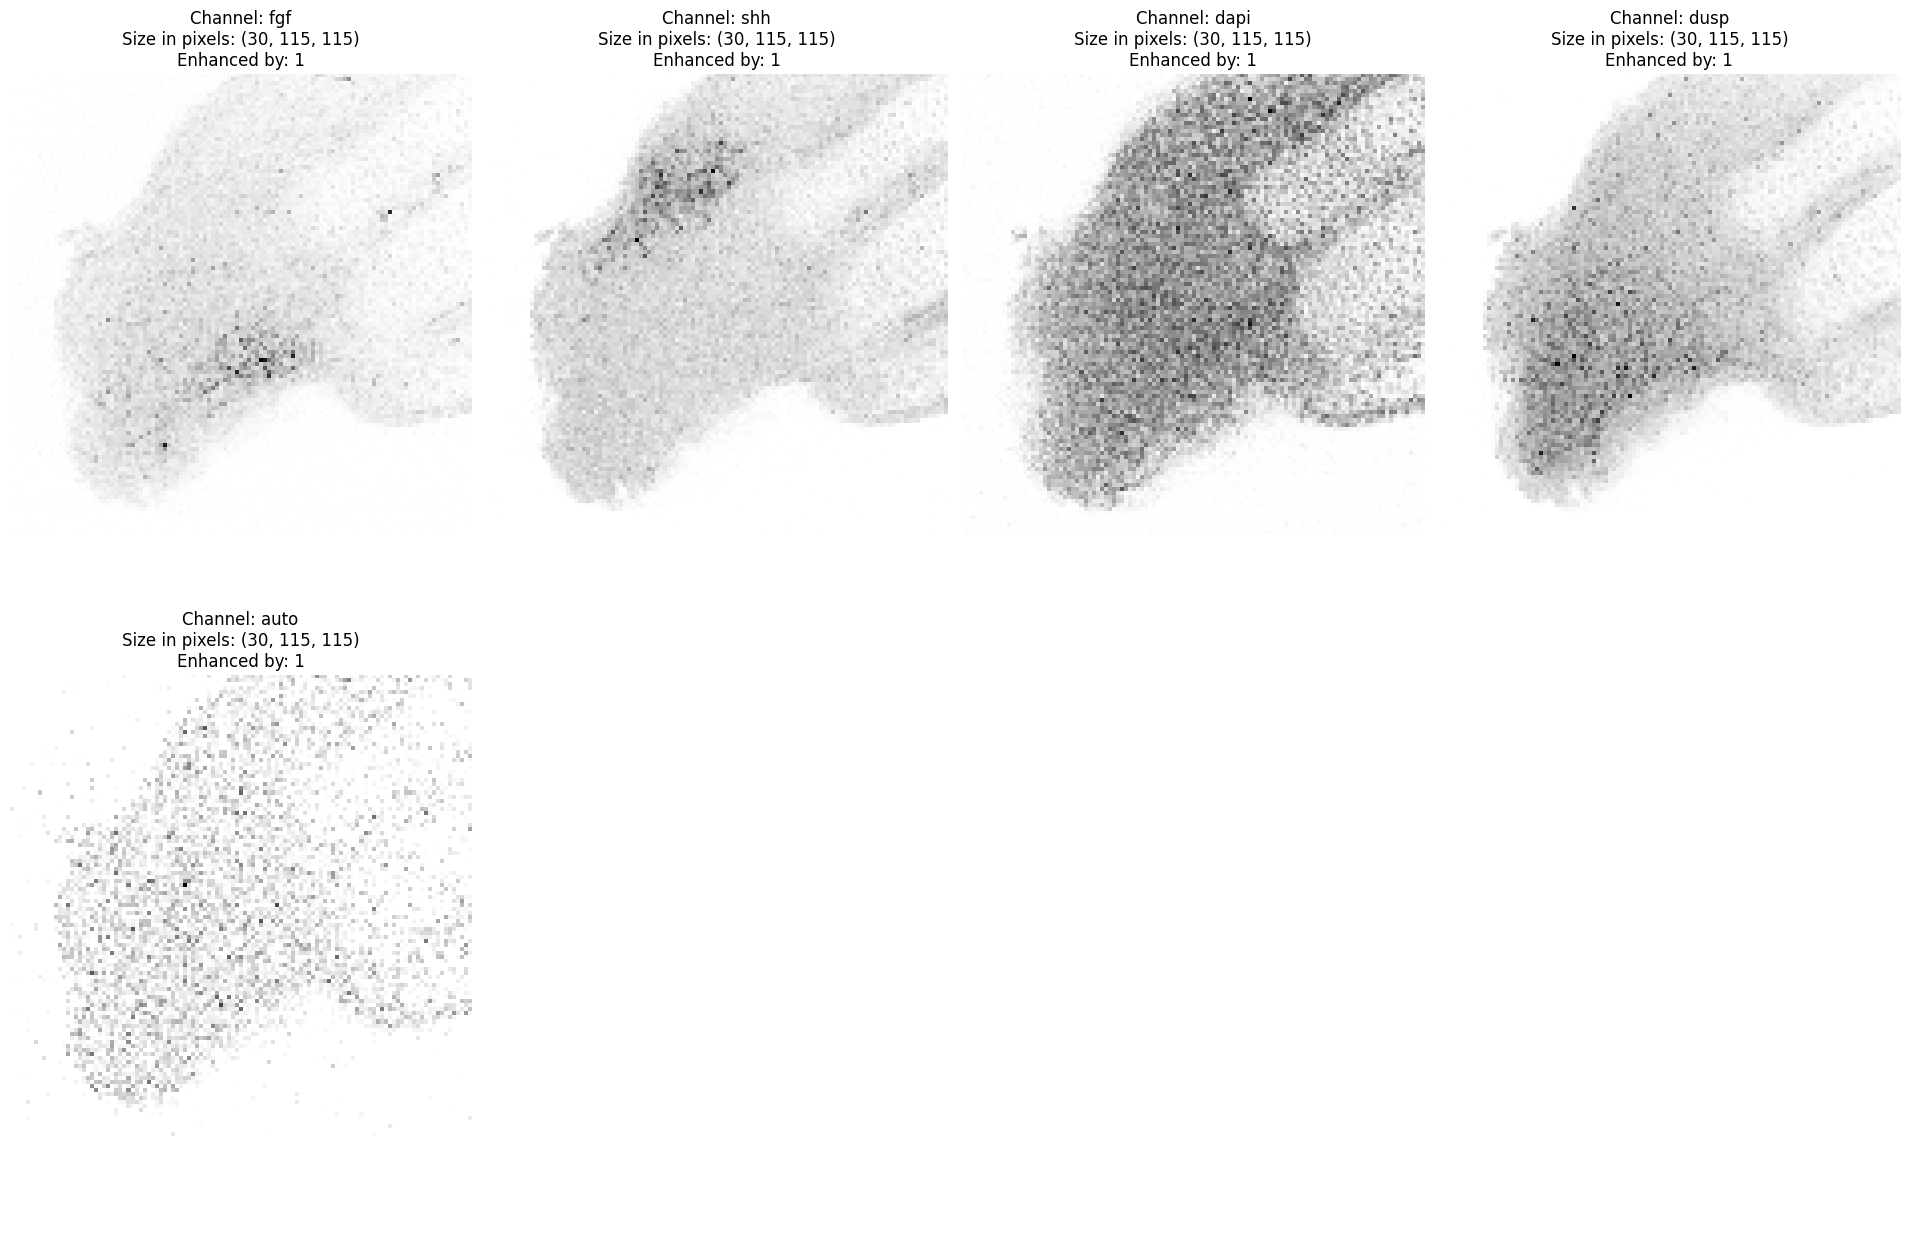

In [14]:
plot.preview(img, 0.5, 1, False, 'none')

# Pre-orient (manually define preferable orientation and cropping)

In [15]:
img = roi.rotate(img, 0, 0, -60)

In [16]:
for key in img.keys():
    img[key] = img[key][:, 38:, :]

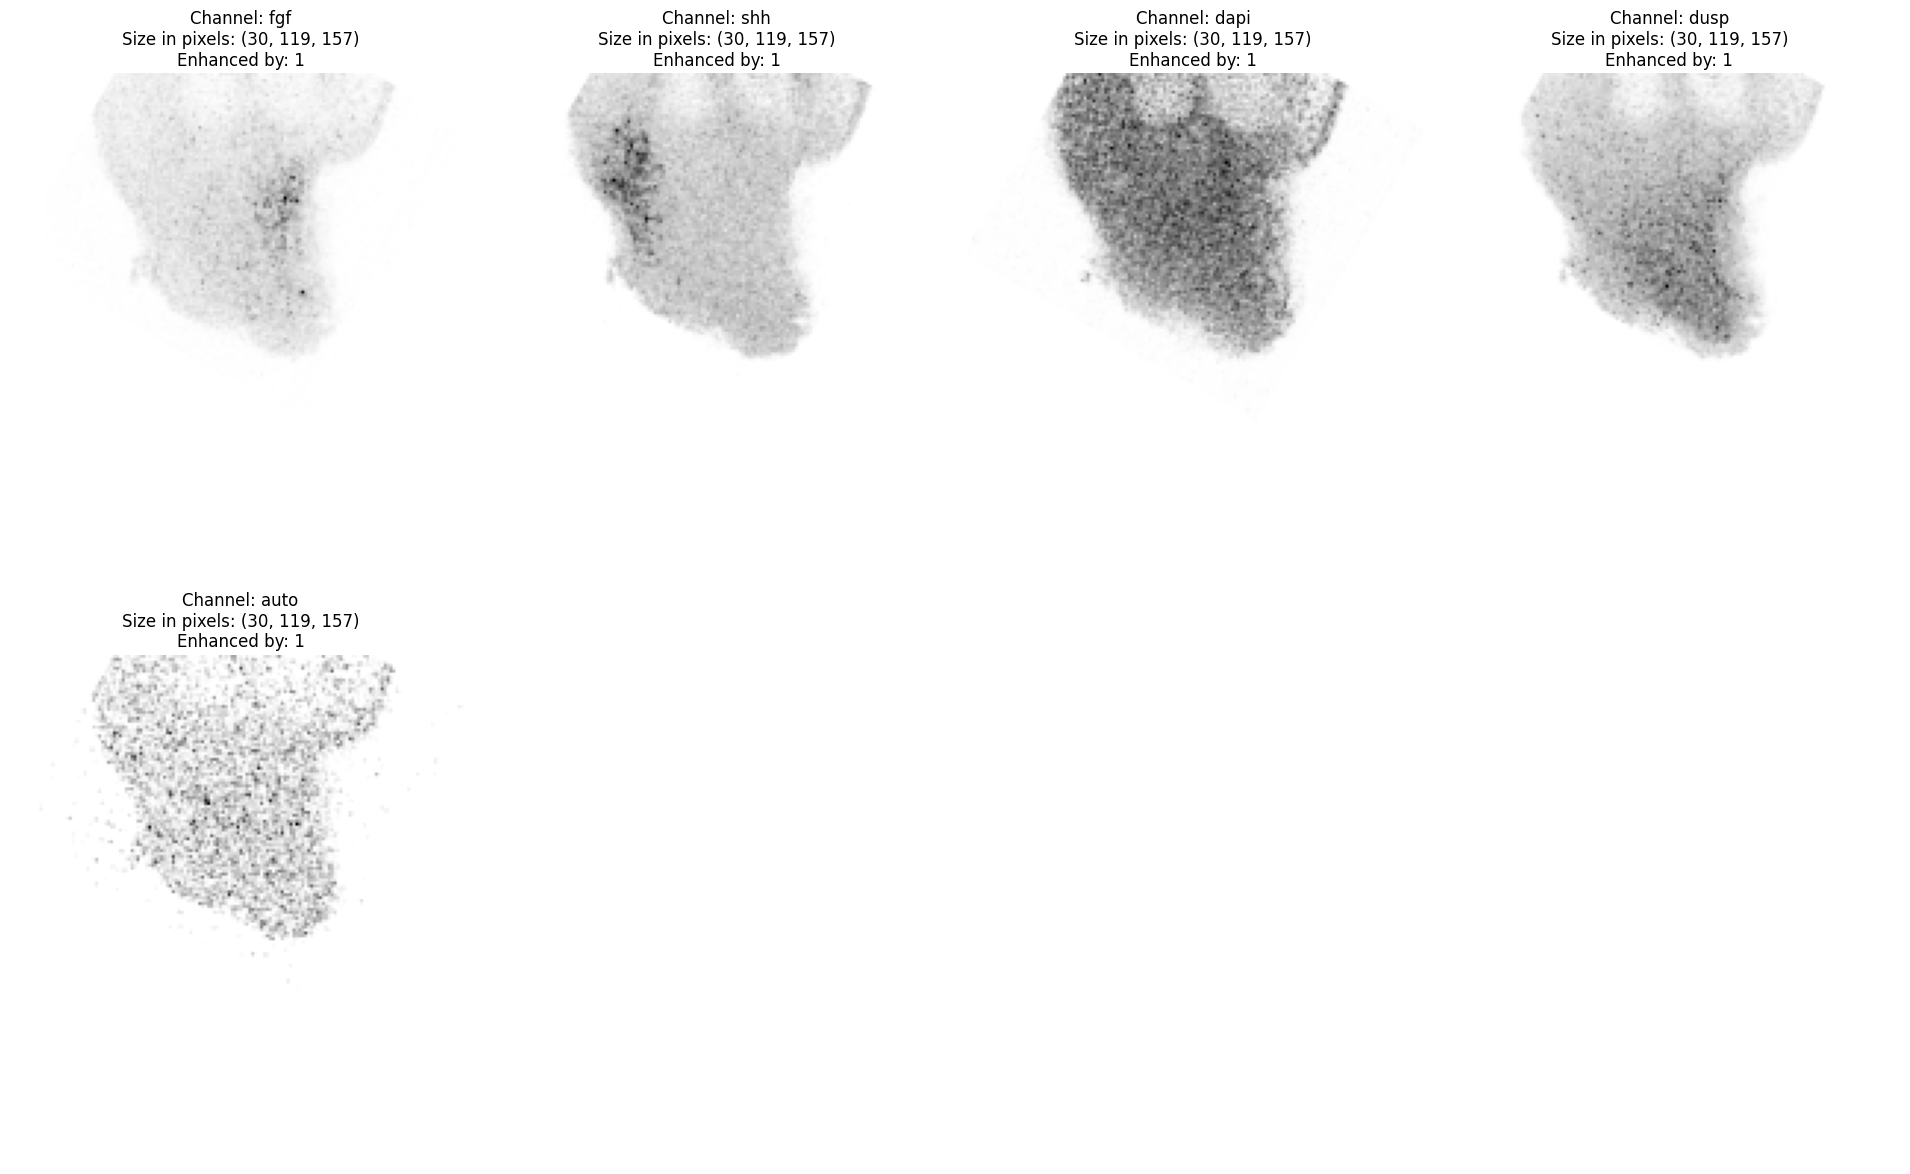

In [17]:
plot.preview(img, 0.5, 1, False, 'none')

# Tissue mask

In [18]:
# pre-trained segmenter using APOC in napari and manually providied lavels blastema and outside tissue
mask_segmeter_path = 'segmenters/tissue_mask_2_5cm.cl'

In [19]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=mask_segmeter_path)
result = segmenter.predict(
    image = img['dusp']
)
segmentation_lpcm = cle.label_pixel_count_map(result)

#keep only the largest object 
img['tissue_mask'] = (np.where(segmentation_lpcm ==  np.max(segmentation_lpcm), 1, 0)).astype( np.uint16 )

In [20]:
@widgets.interact(z_position = (0, 0.9, 0.1))

def preview_images_z(z_position=0.5):
    z = int(z_position * img['tissue_mask'].shape[0])
    plt.imshow( img['tissue_mask'][ z, :, :], cmap='binary')

interactive(children=(FloatSlider(value=0.5, description='z_position', max=0.9), Output()), _dom_classes=('wid…

In [21]:
j = 0
for i in img['tissue_mask']:
    i[-1, :] = 1
    i[:, -1] = 1
    img['tissue_mask'][j, :, :] = ndimage.binary_fill_holes(i)
    j = j + 1

In [22]:
img['tissue_mask'] = mask.morph_change(img['tissue_mask'], 5, True)

# Epidermis mask

In [23]:
# manually define epidermis thickness in pixels
thickness = 5

img['epidermis_mask'] = mask.epiderm(img['tissue_mask'], thickness, extend_along_z=True)

In [24]:
# Crop only tissue
img = mask.crop(img, img['epidermis_mask'])

# Substruct artifacts

In [25]:
# pre-trained segmenter using APOC in napari and manually providied lavels blastema and outside tissue
segmeter_path = 'segmenters/artifacts_2_5cm.cl'

In [26]:
# python code to apply this object segmenter
segmenter = ObjectSegmenter(opencl_filename=mask_segmeter_path)
result = segmenter.predict(
    image = img['auto']
)
segmentation_lpcm = cle.label_pixel_count_map(result)

#keep all
img['auto_mask'] = (np.where(segmentation_lpcm > 0, 1, 0)).astype( np.uint16 )

In [27]:
@widgets.interact(z_position = (0, 0.9, 0.1))

def preview_images_z(z_position=0.5):
    z = int(z_position * img['auto_mask'].shape[0])
    plt.imshow( img['auto_mask'][ z, :, :], cmap='binary')

interactive(children=(FloatSlider(value=0.5, description='z_position', max=0.9), Output()), _dom_classes=('wid…

# Substruct background

In [28]:
import copy
img['tissue_mask_with_epi'] = copy.deepcopy(img['tissue_mask'])
img['tissue_mask']          = img['tissue_mask'] * mask.invert(img['epidermis_mask']) * mask.invert(img['auto_mask'])

In [29]:
for key in img.keys():
    if key.find('mask') < 0:
        img[key] = mask.subtract_bg_clip(img[key], img['tissue_mask'], img['tissue_mask_with_epi'])

Masks for clipping and background subtraction are different.
Mean background value = 407.8741028199727
Masks for clipping and background subtraction are different.
Mean background value = 822.4088132000581
Masks for clipping and background subtraction are different.
Mean background value = 833.880960830413
Masks for clipping and background subtraction are different.
Mean background value = 526.9937261101883
Masks for clipping and background subtraction are different.
Mean background value = 184.88166089965398


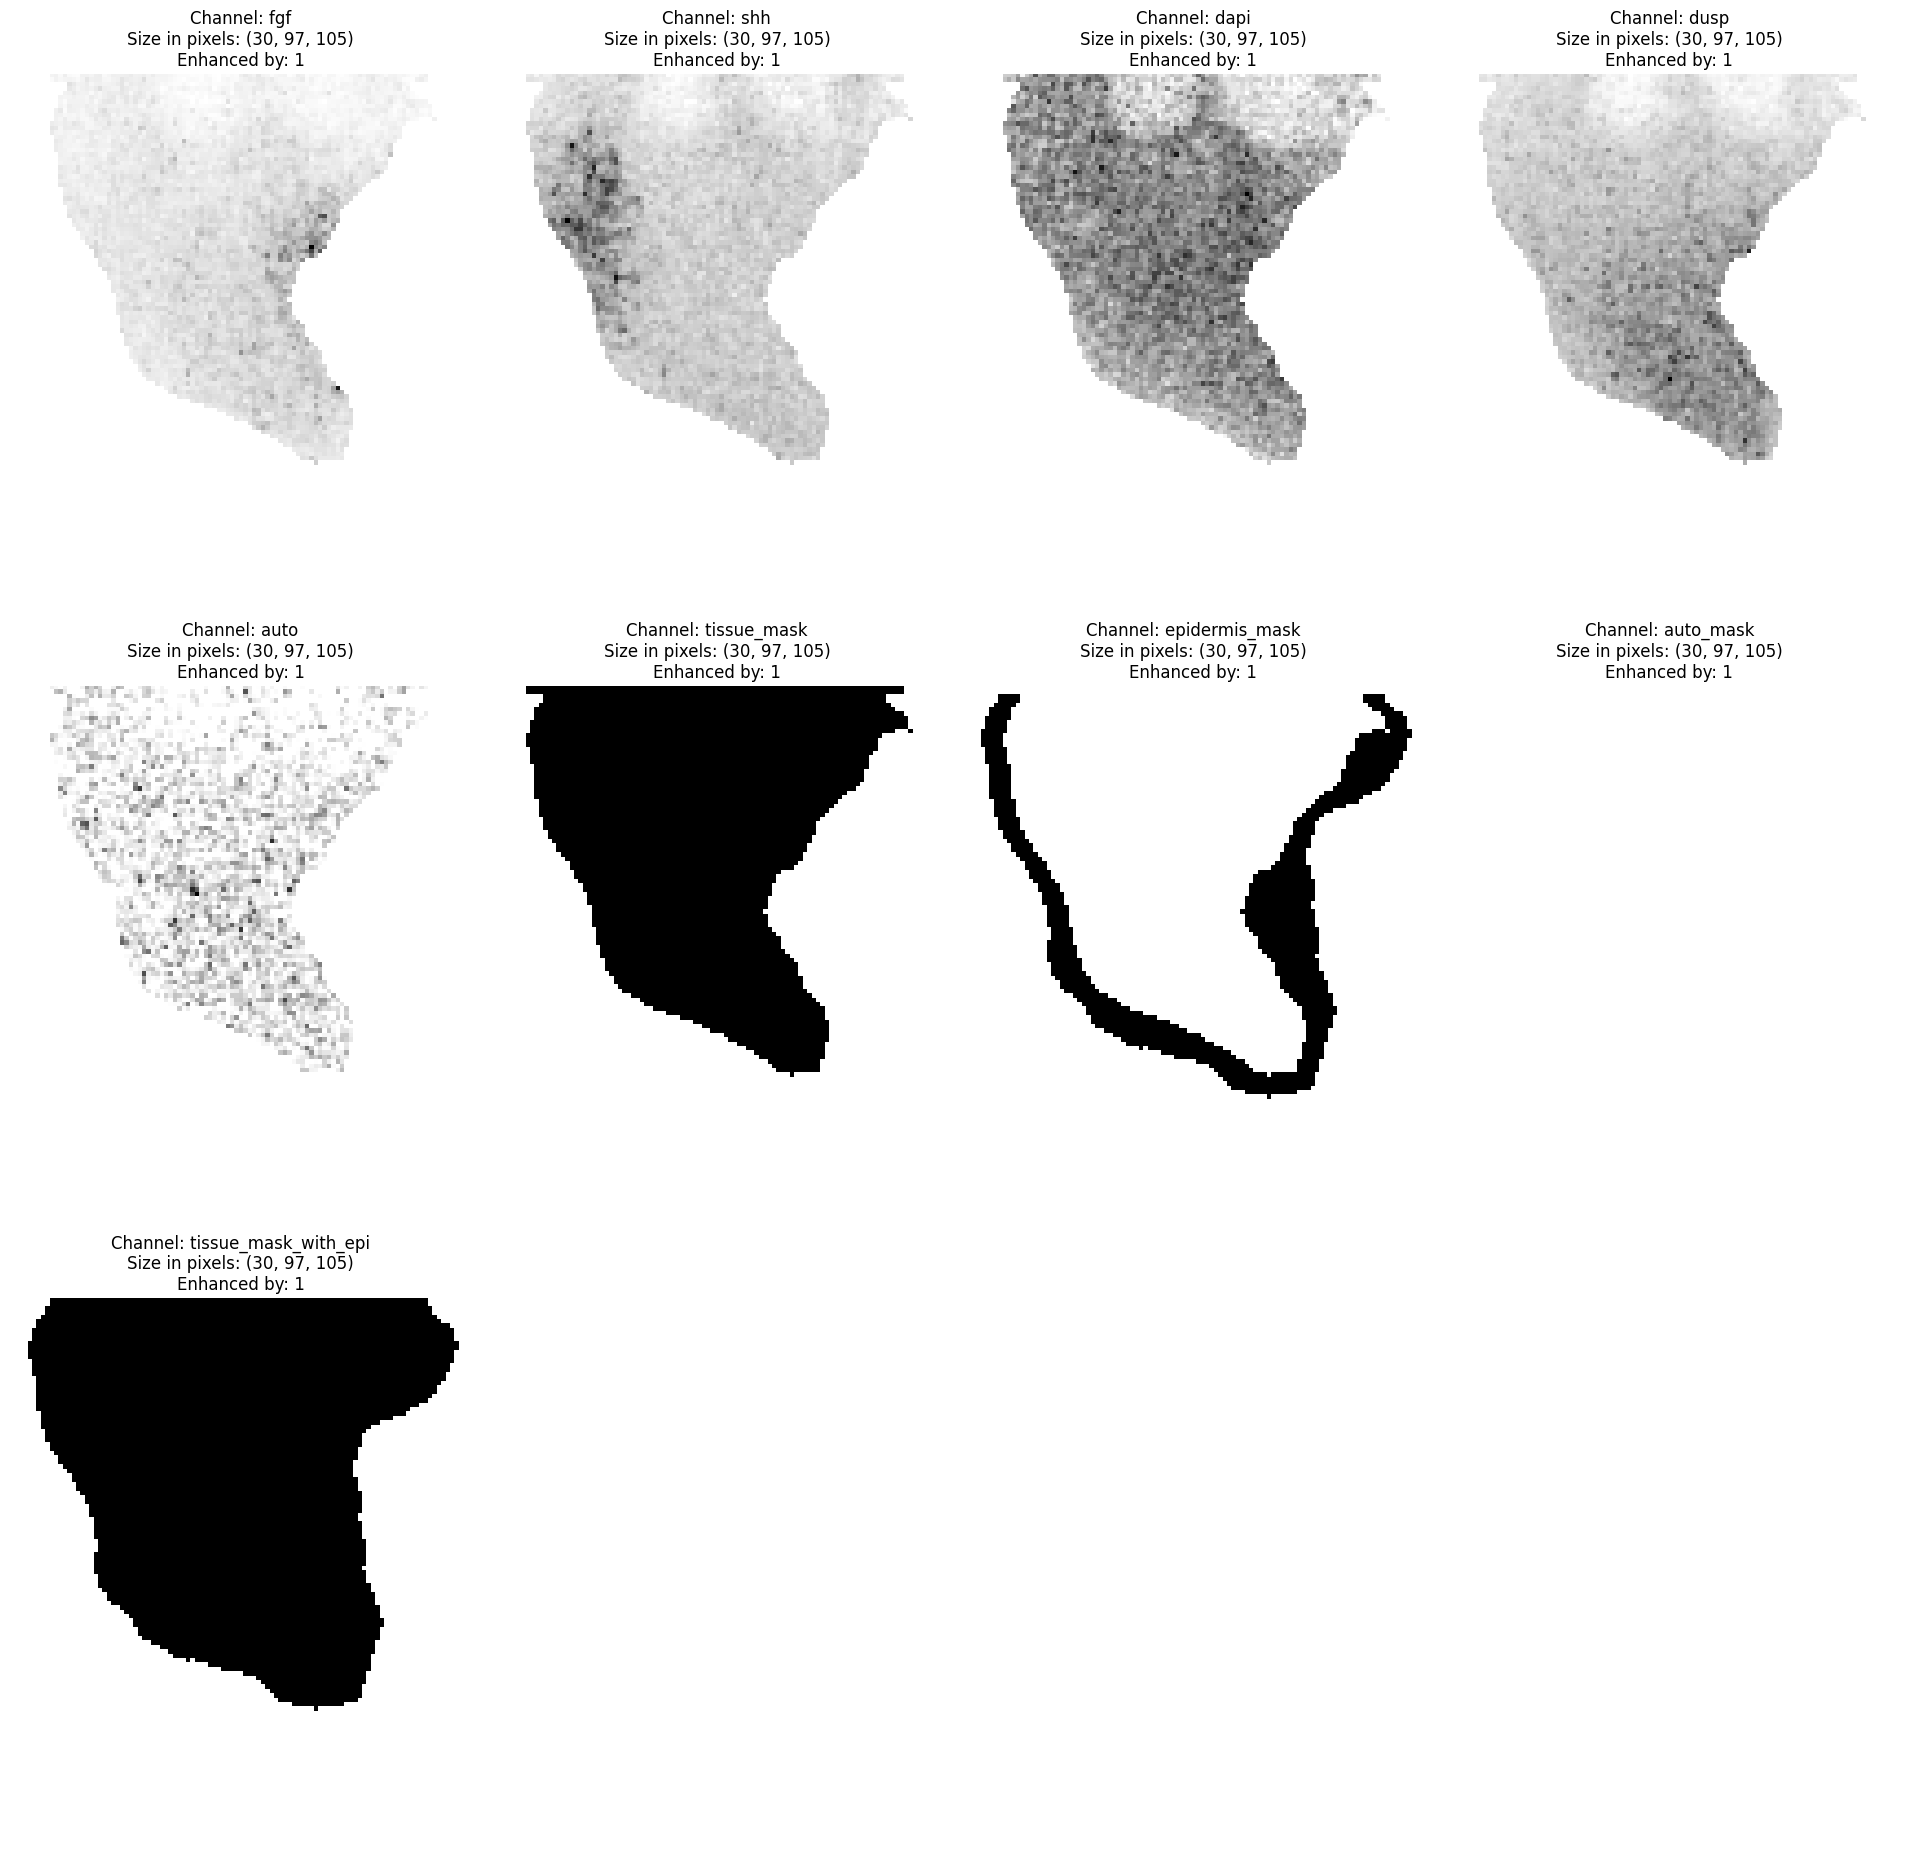

In [30]:
plot.preview(img, 0.5, 1, False, 'none')

# Segment Shh

In [31]:
ch_name = 'shh'

In [32]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.9581784344760292


In [33]:
for pc in [40, 50, 60]: # %
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

# Segment Fgf8

In [34]:
ch_name = 'fgf'

In [35]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.9579899139705178


In [36]:
for pc in [40, 50, 60]: # %
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

## Segment Dusp

In [37]:
ch_name = 'dusp'

In [38]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.9598965018183545


In [39]:
for pc in [40, 50, 60]: # %
    img[ch_name + str(pc) + '_mask'] = (image_filtered > pc * 0.01).astype(np.uint16)
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * img[ch_name + str(pc) + '_mask']

# Save preprocessed image

In [40]:
img_arr = np.array( [img[key] for key in img.keys()] )
img_arr_keys = np.array( [key for key in img.keys()] )

In [41]:
folder_to_save = r'example_pretreated_images/'

In [42]:
file_to_save = f'hcr21_{sample}'
file_to_save

'hcr21_2_5cm_6dpa_noif'

In [43]:
path_to_save = os.path.join(folder_to_save, file_to_save)

In [44]:
np.save( path_to_save, img_arr)

In [45]:
np.save( path_to_save.split('.')[0] + '_keys.npy', img_arr_keys )

In [46]:
np.save( path_to_save.split('.')[0] + '_pixel.npy', pixel_size )